# IT9002 – Natural Language Processing
## E-commerce Product Review Sentiment Analysis Project


## Problem Context

Classify Amazon product reviews as positive or negative using sentiment analysis.

Dataset: Amazon_Reviews.csv (manually uploaded)
- 1-2 stars = negative
- 4-5 stars = positive
- 3 stars excluded


## Dataset Selection & Initial Exploration


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# Load dataset
df1 = pd.read_csv('Amazon_Reviews.csv', sep=',', engine='python')

# Show dataset shape
print("Dataset shape:", df1.shape)

# Show first few rows
print("\nFirst 5 rows:")
df1.head()

Dataset shape: (21214, 9)

First 5 rows:


,Reviewer Name,Profile Link,Country,Review Count,Review Date,Rating,Review Title,Review Text,Date of Experience
0,Eugene ath,/users/66e8185ff1598352d6b3701a,US,1 review,2024-09-16T13:44:26.000Z,Rated 1 out of 5 stars,A Store That Doesn't Want to Sell Anything,"I registered on the website, tried to order a ...","September 16, 2024"
1,Daniel ohalloran,/users/5d75e460200c1f6a6373648c,GB,9 reviews,2024-09-16T18:26:46.000Z,Rated 1 out of 5 stars,Had multiple orders one turned up and…,Had multiple orders one turned up and driver h...,"September 16, 2024"
2,p fisher,/users/546cfcf1000064000197b88f,GB,90 reviews,2024-09-16T21:47:39.000Z,Rated 1 out of 5 stars,I informed these reprobates,I informed these reprobates that I WOULD NOT B...,"September 16, 2024"
3,Greg Dunn,/users/62c35cdbacc0ea0012ccaffa,AU,5 reviews,2024-09-17T07:15:49.000Z,Rated 1 out of 5 stars,Advertise one price then increase it on website,I have bought from Amazon before and no proble...,"September 17, 2024"
4,Sheila Hannah,/users/5ddbe429478d88251550610e,GB,8 reviews,2024-09-16T18:37:17.000Z,Rated 1 out of 5 stars,If I could give a lower rate I would,If I could give a lower rate I would! I cancel...,"September 16, 2024"


In [ ]:
# Convert 'Rating' column to numeric for processing
df1['numeric_rating'] = pd.to_numeric(df1['Rating'].str.extract(r'(\d+)')[0], errors='coerce')

# Drop rows where 'numeric_rating' is NaN (i.e., rating could not be extracted)
df1.dropna(subset=['numeric_rating'], inplace=True)

# Now convert to integer, as there should be no NaNs left in this column.
df1['numeric_rating'] = df1['numeric_rating'].astype(int)

# Show rating distribution
print("Rating distribution:")
print(df1['numeric_rating'].value_counts().sort_index())

# Remove 3-star reviews
df1 = df1[df1['numeric_rating'] != 3].copy()

# Create binary labels: 1-2 stars = 0 (negative), 4-5 stars = 1 (positive)
df1['sentiment'] = 0
df1.loc[df1['numeric_rating'] >= 4, 'sentiment'] = 1

print("\nSentiment distribution:")
print(df1['sentiment'].value_counts())

Rating distribution:
numeric_rating
1    13123
2     1227
3      885
4     1292
5     4528
Name: count, dtype: int64

Sentiment distribution:
sentiment
0    14350
1     5820
Name: count, dtype: int64


## Text Preprocessing


### Lowercasing


In [ ]:
# Convert text to lowercase
df1['text_lower'] = df1['Review Text'].str.lower()

# Show example
print("Original:", df1['Review Text'].iloc[0][:100])
print("Lowercase:", df1['text_lower'].iloc[0][:100])

Original: I registered on the website, tried to order a laptop, entered all the details, but instead of chargi
Lowercase: i registered on the website, tried to order a laptop, entered all the details, but instead of chargi


### Tokenization


In [ ]:
# Tokenize text
df1['tokens'] = df1['text_lower'].fillna('').apply(word_tokenize)

# Show example
print("Lowercase text:", df1['text_lower'].iloc[0][:100])
print("Tokens:", df1['tokens'].iloc[0][:20])

Lowercase text: i registered on the website, tried to order a laptop, entered all the details, but instead of chargi
Tokens: ['i', 'registered', 'on', 'the', 'website', ',', 'tried', 'to', 'order', 'a', 'laptop', ',', 'entered', 'all', 'the', 'details', ',', 'but', 'instead', 'of']


### Stopword Removal


In [ ]:
# Remove stopwords
stop_words = set(stopwords.words('english'))
df1['tokens_no_stop'] = df1['tokens'].apply(lambda tokens: [t for t in tokens if t not in stop_words])

# Show example
print("Before stopword removal:", len(df1['tokens'].iloc[0]), "tokens")
print("After stopword removal:", len(df1['tokens_no_stop'].iloc[0]), "tokens")
print("Tokens:", df1['tokens_no_stop'].iloc[0][:20])

Before stopword removal: 128 tokens
After stopword removal: 74 tokens
Tokens: ['registered', 'website', ',', 'tried', 'order', 'laptop', ',', 'entered', 'details', ',', 'instead', 'charging', 'sending', 'product', ',', 'froze', 'account', ',', 'demanding', 'various']


### Stemming


In [ ]:
# Apply stemming
stemmer = PorterStemmer()
df1['tokens_stemmed'] = df1['tokens_no_stop'].apply(lambda tokens: [stemmer.stem(t) for t in tokens])

# Join tokens back to text for vectorization
df1['preprocessed_text'] = df1['tokens_stemmed'].apply(lambda tokens: ' '.join(tokens))

# Show example
print("Stemmed tokens:", df1['tokens_stemmed'].iloc[0][:20])
print("Preprocessed text:", df1['preprocessed_text'].iloc[0][:100])

Stemmed tokens: ['regist', 'websit', ',', 'tri', 'order', 'laptop', ',', 'enter', 'detail', ',', 'instead', 'charg', 'send', 'product', ',', 'froze', 'account', ',', 'demand', 'variou']
Preprocessed text: regist websit , tri order laptop , enter detail , instead charg send product , froze account , deman


## Text Representation


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Bag of Words (Unigrams)
bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(df1['preprocessed_text'])

print("Bag of Words matrix shape:", X_bow.shape)
print("Number of BoW features:", X_bow.shape[1])


Bag of Words matrix shape: (20170, 22111)
Number of BoW features: 22111


In [ ]:
# N-grams (Bigrams)
ngram_vectorizer = CountVectorizer(ngram_range=(2, 2))
X_ngram = ngram_vectorizer.fit_transform(df1['preprocessed_text'])

print("N-gram matrix shape:", X_ngram.shape)
print("Number of N-gram features:", X_ngram.shape[1])


N-gram matrix shape: (20170, 362035)
Number of N-gram features: 362035


In [ ]:
# Create TF-IDF features
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df1['preprocessed_text'])
y = df1['sentiment']

print("TF-IDF matrix shape:", X.shape)
print("Number of features:", X.shape[1])

TF-IDF matrix shape: (20170, 22111)
Number of features: 22111


## Text Classification


In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])


Training set size: 16136
Test set size: 4034


### Model 1: Multinomial Naive Bayes


In [ ]:
# Train Multinomial Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_predictions = nb_model.predict(X_test)
print("Multinomial Naive Bayes trained")


Multinomial Naive Bayes trained


### Model 2: Logistic Regression


In [ ]:
# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
print("Logistic Regression trained")


Logistic Regression trained


## Evaluation


In [ ]:
# Calculate accuracy
from sklearn.metrics import precision_score, recall_score, f1_score

nb_accuracy = accuracy_score(y_test, nb_predictions)
lr_accuracy = accuracy_score(y_test, lr_predictions)

print("Multinomial Naive Bayes Accuracy:", nb_accuracy)
print("Logistic Regression Accuracy:", lr_accuracy)

# Calculate precision, recall, F1 for Naive Bayes
nb_precision = precision_score(y_test, nb_predictions)
nb_recall = recall_score(y_test, nb_predictions)
nb_f1 = f1_score(y_test, nb_predictions)

print("\nMultinomial Naive Bayes Precision:", nb_precision)
print("Multinomial Naive Bayes Recall:", nb_recall)
print("Multinomial Naive Bayes F1-score:", nb_f1)

# Calculate precision, recall, F1 for Logistic Regression
lr_precision = precision_score(y_test, lr_predictions)
lr_recall = recall_score(y_test, lr_predictions)
lr_f1 = f1_score(y_test, lr_predictions)

print("\nLogistic Regression Precision:", lr_precision)
print("Logistic Regression Recall:", lr_recall)
print("Logistic Regression F1-score:", lr_f1)


Multinomial Naive Bayes Accuracy: 0.850272682201289
Logistic Regression Accuracy: 0.9340604858701042

Multinomial Naive Bayes Precision: 0.93343653250774
Multinomial Naive Bayes Recall: 0.5180412371134021
Multinomial Naive Bayes F1-score: 0.6662983425414365

Logistic Regression Precision: 0.9251893939393939
Logistic Regression Recall: 0.8393470790378007
Logistic Regression F1-score: 0.8801801801801802


In [ ]:
# Confusion matrix for Naive Bayes
nb_cm = confusion_matrix(y_test, nb_predictions)
print("Naive Bayes Confusion Matrix:")
print(nb_cm)


Naive Bayes Confusion Matrix:
[[2827   43]
 [ 561  603]]


In [ ]:
# Confusion matrix for Logistic Regression
lr_cm = confusion_matrix(y_test, lr_predictions)
print("Logistic Regression Confusion Matrix:")
print(lr_cm)


Logistic Regression Confusion Matrix:
[[2791   79]
 [ 187  977]]


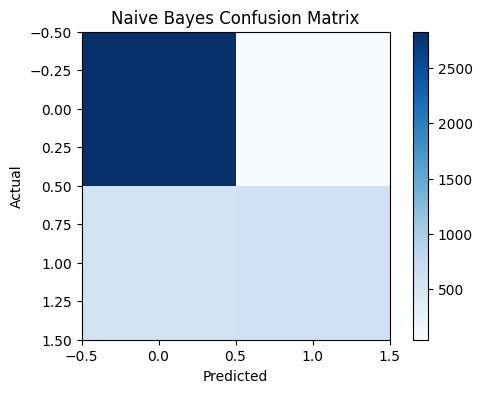

In [ ]:
# Plot confusion matrix for Naive Bayes
plt.figure(figsize=(6, 4))
plt.imshow(nb_cm, cmap='Blues')
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar()
plt.show()


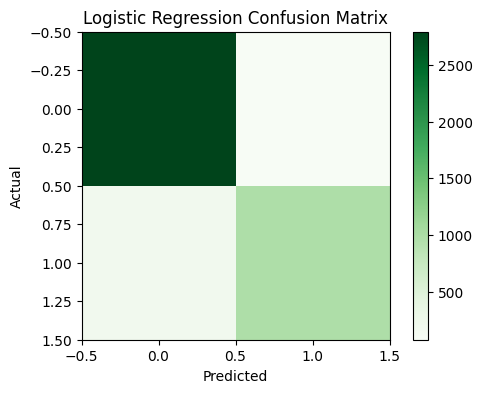

In [ ]:
# Plot confusion matrix for Logistic Regression
plt.figure(figsize=(6, 4))
plt.imshow(lr_cm, cmap='Greens')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar()
plt.show()
